Please enter number of future time periods to predict :10
Enter the frequency of your data. Example 1T for one munute, 10T for ten minutes 1D for daily ETC.:1D
                    Open          High           Low         Close  \
Date                                                                 
2022-04-14  41160.218750  41451.480469  39695.746094  39935.515625   
2022-04-15  39939.402344  40617.722656  39866.832031  40553.464844   
2022-04-16  40552.316406  40633.679688  40078.425781  40424.484375   
2022-04-17  40417.777344  40570.726563  39620.894531  39716.953125   
2022-04-18  39646.859375  39861.007813  38725.570313  38958.406250   

               Adj Close        Volume  
Date                                    
2022-04-14  39935.515625  2.434200e+10  
2022-04-15  40553.464844  2.175686e+10  
2022-04-16  40424.484375  1.683315e+10  
2022-04-17  39716.953125  1.908763e+10  
2022-04-18  38958.406250  2.436432e+10  
366
Epoch 1/10
95/95 [==============================] - 4s 15m

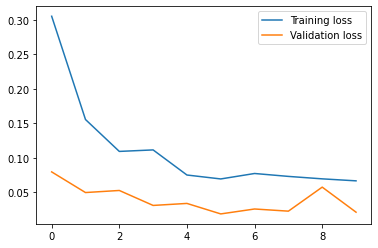

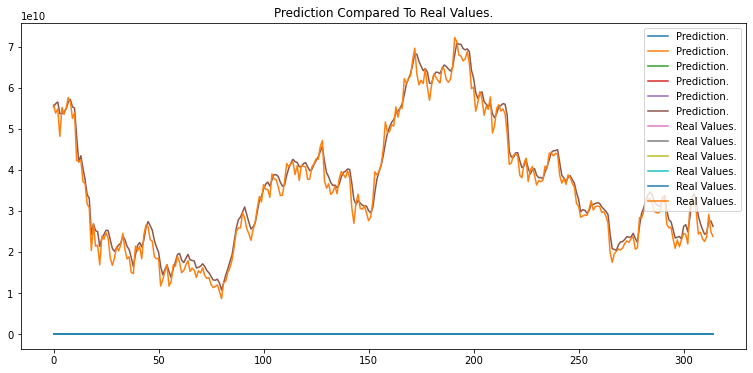

  FutureDates    Prediction
0  2022-04-18  44946.839844
1  2022-04-19  44150.433594
2  2022-04-20  41768.179688
3  2022-04-21  40671.585938
4  2022-04-22  39811.292969
5  2022-04-23  39101.613281
6  2022-04-24  39333.972656
7  2022-04-25  41070.250000
8  2022-04-26  41026.898438
9  2022-04-27  40252.183594


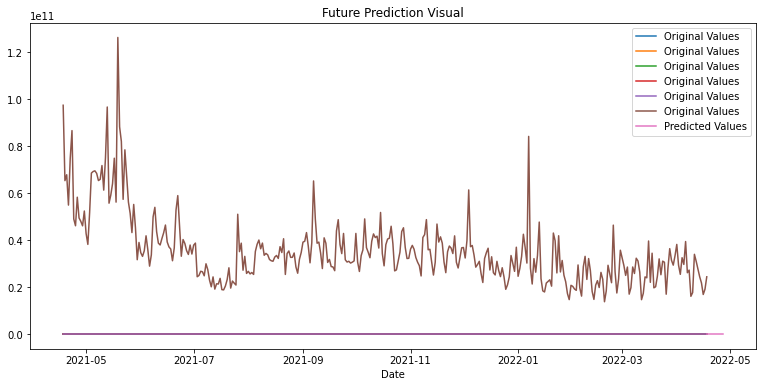

In [5]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


future_days = input("Please enter number of future time periods to predict :")
future_days = int(future_days)
time_freq = input("Enter the frequency of your data. Example 1T for one munute, 10T for ten minutes 1D for daily ETC.:")

#Data import.
#data = pd.read_csv("short.csv",index_col='date', parse_dates=True)
data = pd.read_csv("2021_2022.csv", index_col=0, parse_dates=True)
#data = pd.read_csv("2021_2022.csv", index_col=0, parse_dates=True, header=None)
data = data.astype('float')
print(data.tail())
datelist_train = list(data.index)
print(len(data))
#Scale data to a range of -1,1 and split to training and testing set.
scaler = StandardScaler()
scaler = scaler.fit(data)
dataset = scaler.transform(data)
train_data = int(len(dataset) * 0.9)
test_data = (int(len(dataset) - train_data ))
train, test = dataset[0:train_data], dataset[train_data:len(dataset)]
# Reshape data to lenght, timesteps and number of features.
n_future = 1 
n_past = 14 
def create_dataset(my_data, n_future, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(my_data) - n_future +1):
        dataX.append(my_data[i - n_past:i, 0:my_data.shape[1]])
        dataY.append(my_data[i + n_future - 1:i + n_future, 0])
    return np.array(dataX), np.array(dataY)
trainX, trainY = create_dataset(train, n_future, n_past)
testX, testY = create_dataset(test, n_future, n_past)
#RNN model  starts.
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
history = model.fit(trainX, trainY, epochs=10,validation_split=0.1, batch_size=3)
model.summary()
# Plot model loss comparison.
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
#Chart to compare real vs predicted values in the model training.
plt.figure(figsize=(13,6))
test_prediction0 = model.predict(trainX)
test_prediction1 = np.repeat(test_prediction0, data.shape[1], axis=-1)
real0 = np.repeat(trainY, data.shape[1], axis=-1)
test_prediction = scaler.inverse_transform(test_prediction1)
real = scaler.inverse_transform(real0)
plt.title("Prediction Compared To Real Values.")
plt.plot(test_prediction, label = "Prediction.")
plt.plot(real, label = "Real Values.")
plt.legend()
plt.savefig('Traincompare.png')
plt.show()
# Create future date list.
future_prediction_real = future_days
datelist_future = pd.date_range(datelist_train[-1], periods=future_prediction_real, freq=time_freq).tolist()
# Predict future days.
prediction = model.predict(trainX[-future_prediction_real:])
prediction_copies = np.repeat(prediction, data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
# Create date list table and future pediction table and combine side by side.
datelist_future_ = []
for i in datelist_future:
    datelist_future_.append(i.date())

data_forecust = pd.DataFrame({'FutureDates':np.array(datelist_future), 'Prediction':y_pred_future})
data_forecust['FutureDates']=pd.to_datetime(data_forecust['FutureDates'])

print(pd.DataFrame(data_forecust))
#Figure to visualise the models future prediction.
plt.figure(figsize=(13,6))
plt.title("Future Prediction Visual")
plt.xlabel("Date")
plt.plot(data, label="Original Values")
plt.plot(datelist_future,y_pred_future, label = "Predicted Values")
plt.legend()
plt.savefig('futurefig.png')
plt.show()

